In [23]:
from datetime import datetime, timedelta
import pandas as pd
def load_and_preprocess_vix_data():
    
    """Load and preprocess VIX data from CSV with proper datetime parsing"""
    try:
        # Load VIX data with proper datetime parsing
        vix_data = pd.read_csv(
            'hist_india_vix_-18-06-2024-to-17-06-2025.csv',
            parse_dates=['Date '],
            date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%Y')
              # Specify your actual date format
        )

        vix_data.columns = [
        'date', 'vix_open', 'vix_high', 'vix_low', 'vix_close',
        'vix_prev_close', 'vix_change', 'vix_pct_change']

        
        # Set date as index with proper datetime handling
        vix_data['date'] = pd.to_datetime(vix_data['date'], format='%Y-%m-%d').dt.tz_localize(None)  # Specify format
        vix_data.set_index('date', inplace=True)
        return vix_data
    except Exception as e:
        print(f"Error loading VIX data: {str(e)}")
        vix_data = None

C:\Users\dasdi\AppData\Local\Temp\ipykernel_22960\3645163300.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  vix_data = pd.read_csv(



          COMPREHENSIVE INDIAN MARKET ANALYSIS

=== TREND & MOMENTUM ===
SENSEX: 81556.38 | 12MA: 81764.37 | 26MA: 81684.04
Trend: Bearish | RSI (14-day): 51.03 → Neutral

=== VOLATILITY ===
India VIX: 14.84 (Mean: 14.84, 75th %ile: 15.65)
VIX Sentiment: Moderate (Neutral)

=== MARKET BREADTH ===
Advance-Decline Ratio: 0.85 → 🔍 Neutral
Smallcap 250 (5d Return): -2.19% | Midcap 150: -2.23%

=== SECTORAL PERFORMANCE ===
              5d Return %
Nifty IT         0.589051
Nifty Auto       0.134331
Nifty Bank      -0.803726
Nifty FMCG      -1.396994
Nifty Pharma    -2.656315

Sector Sentiment: ✅ Risk-On (Cyclicals Leading)
Strongest Sector: Nifty IT | Weakest Sector: Nifty Pharma

=== COMBINED INTERPRETATION ===
🔍 NEUTRAL: Mixed signals. Wait for confirmation.


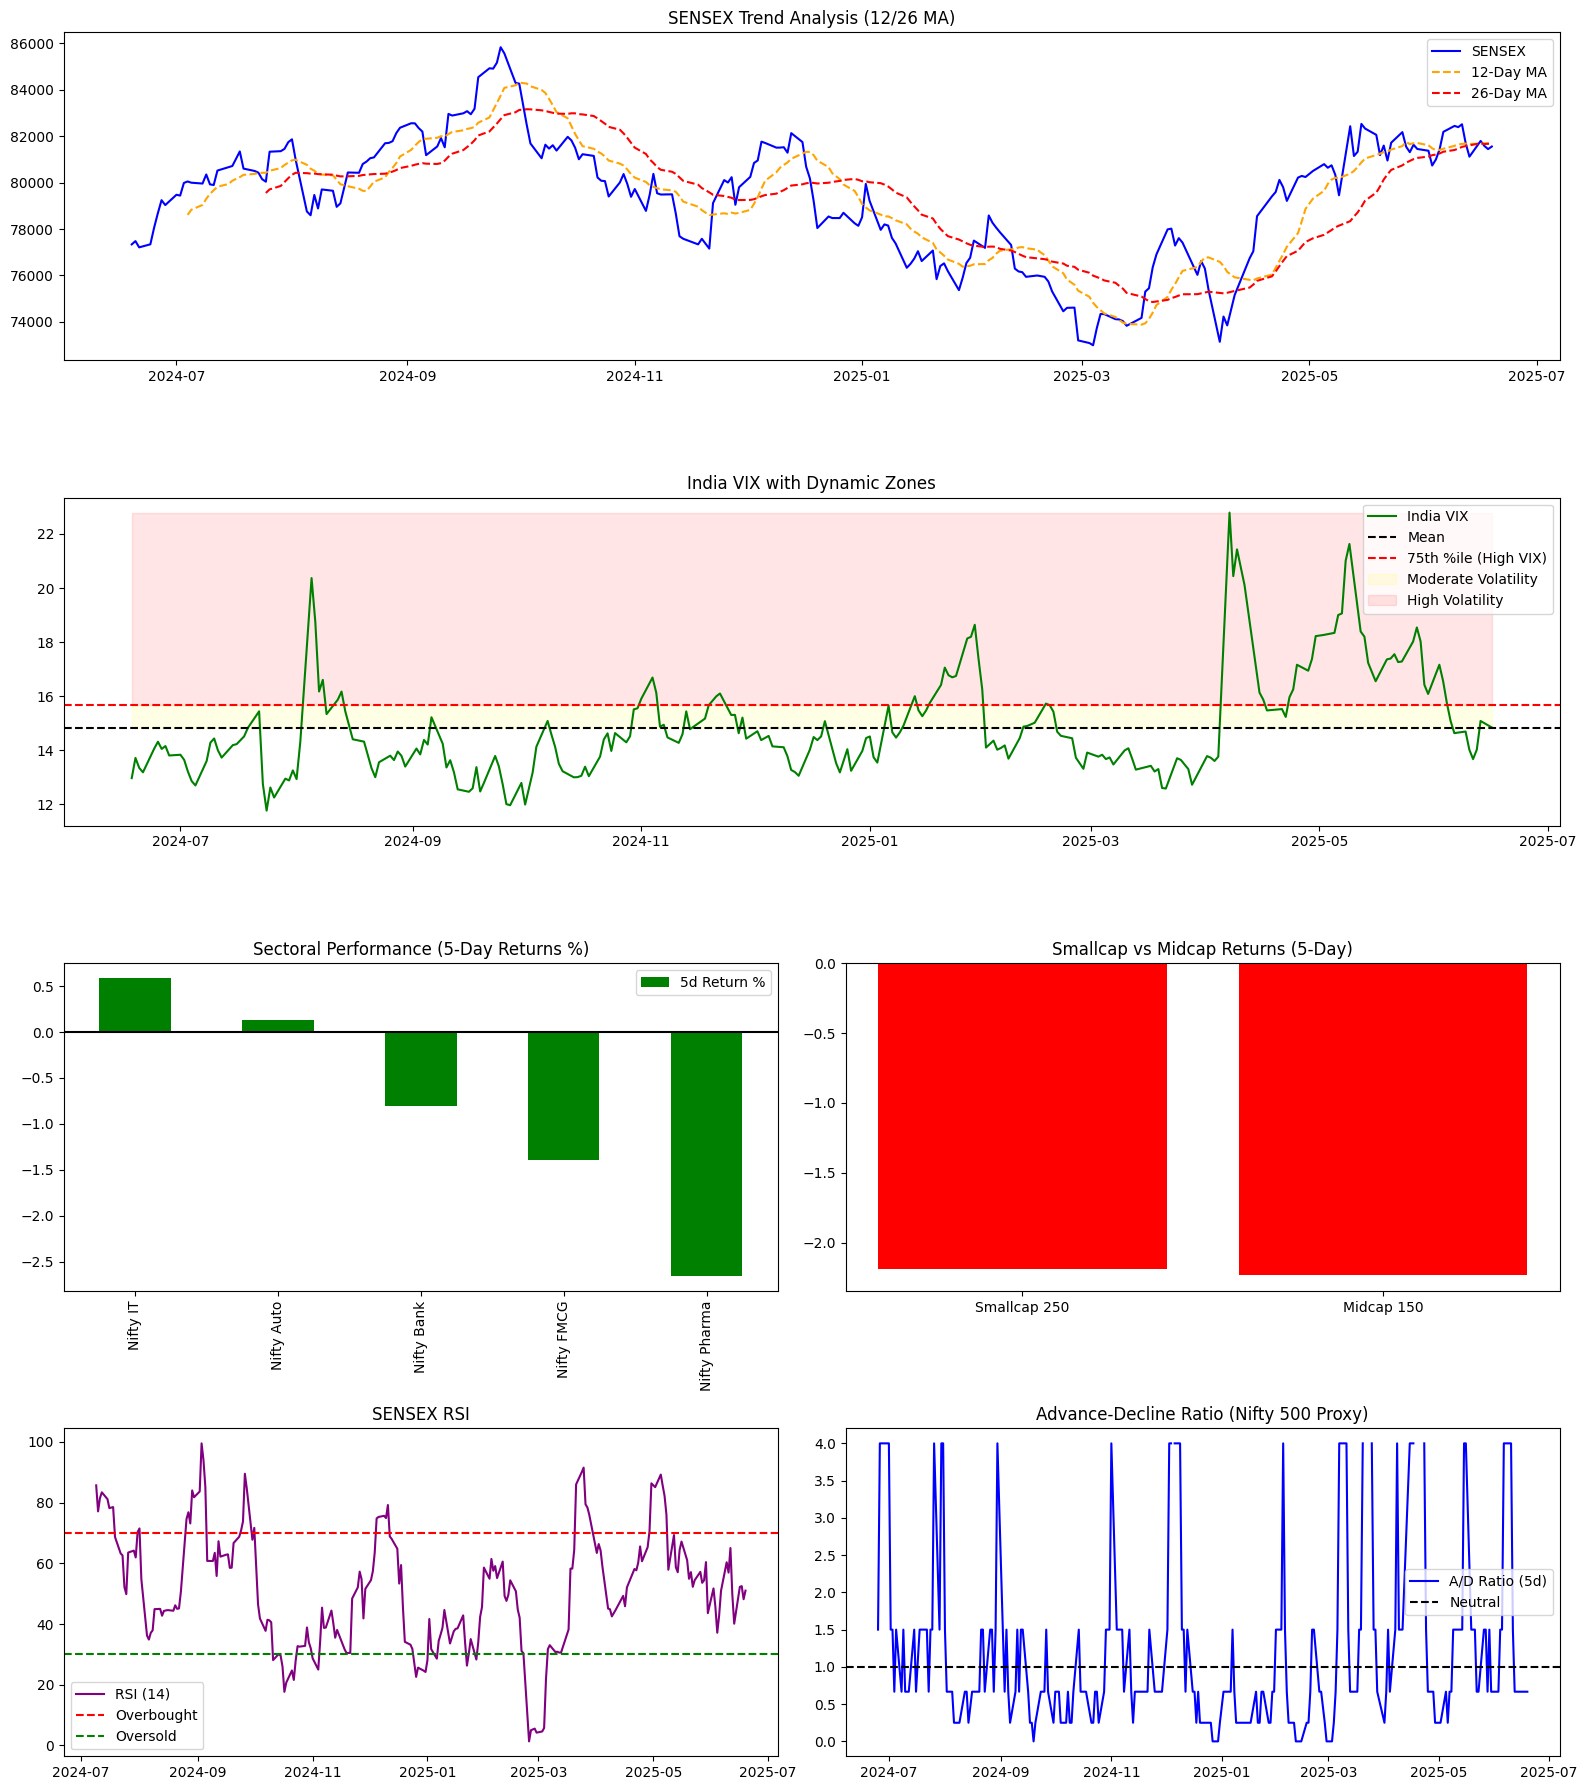

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ===== 1. Fetch Data =====
def fetch_data(ticker, period="1y"):
    tck = yf.Ticker(ticker)
    return tck.history(period=period)

# Benchmark Indices
sensex = fetch_data("^BSESN")
india_vix = load_and_preprocess_vix_data()
nifty_smallcap = fetch_data("0P0001PR8B.BO")  # SBI NIFTY Small-cap index 250
nifty_midcap = fetch_data("0P0001NYM3.BO")    # ICICI Pru Nifty Midcap 150 Idx Reg Gr

# Sectoral Indices
sectors = {
    "Nifty Bank": "^NSEBANK",
    "Nifty IT": "^CNXIT",
    "Nifty FMCG": "^CNXFMCG",
    "Nifty Auto": "^CNXAUTO",
    "Nifty Pharma": "^CNXPHARMA",
}
sector_data = {sector: fetch_data(ticker, "3mo") for sector, ticker in sectors.items()}

# ===== 2. Calculate Indicators =====
# Moving Averages (SENSEX) - Changed to 12 and 26 days
sensex['MA_12'] = sensex['Close'].rolling(window=12).mean()
sensex['MA_26'] = sensex['Close'].rolling(window=26).mean()

# Dynamic VIX Thresholds
vix_mean = india_vix['vix_close'].mean()
vix_std = india_vix['vix_close'].std()
vix_75perc = np.percentile(india_vix['vix_close'], 75)

# RSI (14-day for SENSEX)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

sensex['RSI'] = compute_rsi(sensex['Close'])

# Advance-Decline Ratio (Proxy: Nifty 500 A/D)
nifty_500 = fetch_data("^CRSLDX")  # Nifty 500 (proxy)
nifty_500['Advance'] = nifty_500['Close'] > nifty_500['Open']
nifty_500['Decline'] = nifty_500['Close'] < nifty_500['Open']
ad_ratio = nifty_500['Advance'].sum() / max(nifty_500['Decline'].sum(), 1)  # Avoid division by zero

# Sectoral Performance (5-day returns)
sector_returns = pd.DataFrame({
    sector: data['Close'].pct_change(5).iloc[-1] * 100  # 5d returns in %
    for sector, data in sector_data.items()
}, index=["5d Return %"]).T.sort_values("5d Return %", ascending=False)

# Smallcap/Midcap Performance
smallcap_return = nifty_smallcap['Close'].pct_change(5).iloc[-1] * 100
midcap_return = nifty_midcap['Close'].pct_change(5).iloc[-1] * 100

# ===== 3. Generate Signals =====
# Trend Signal - Updated to use 12 and 26 MA
trend = "Bullish" if (sensex['Close'].iloc[-1] > sensex['MA_12'].iloc[-1] and 
                      sensex['Close'].iloc[-1] > sensex['MA_26'].iloc[-1]) else "Bearish"

# VIX Signal
if india_vix['vix_close'].iloc[-1] < vix_mean:
    vix_sentiment = "Low (Bullish)"
elif india_vix['vix_close'].iloc[-1] > vix_75perc:
    vix_sentiment = "Very High (Bearish)"
else:
    vix_sentiment = "Moderate (Neutral)"

# Sector Signal
top_sector = sector_returns.index[0]
if "Bank" in top_sector or "Auto" in top_sector or "IT" in top_sector:
    sector_sentiment = "✅ Risk-On (Cyclicals Leading)"
elif "FMCG" in top_sector or "Pharma" in top_sector:
    sector_sentiment = "⚠️ Risk-Off (Defensives Leading)"
else:
    sector_sentiment = "🔍 Neutral (Mixed)"

# Breadth Signal
if ad_ratio > 1.5:
    breadth_sentiment = "✅ Broad Participation (Bullish)"
elif ad_ratio < 0.7:
    breadth_sentiment = "❌ Weak Participation (Bearish)"
else:
    breadth_sentiment = "🔍 Neutral"

# RSI Signal
rsi = sensex['RSI'].iloc[-1]
if rsi > 70:
    rsi_sentiment = "⚠️ Overbought (Caution)"
elif rsi < 30:
    rsi_sentiment = "📈 Oversold (Opportunity)"
else:
    rsi_sentiment = "Neutral"

# ===== 4. Print Analysis =====
print("\n" + "="*60)
print("          COMPREHENSIVE INDIAN MARKET ANALYSIS")
print("="*60)

print("\n=== TREND & MOMENTUM ===")
print(f"SENSEX: {sensex['Close'].iloc[-1]:.2f} | 12MA: {sensex['MA_12'].iloc[-1]:.2f} | 26MA: {sensex['MA_26'].iloc[-1]:.2f}")
print(f"Trend: {trend} | RSI (14-day): {rsi:.2f} → {rsi_sentiment}")

print("\n=== VOLATILITY ===")
print(f"India VIX: {india_vix['vix_close'].iloc[-1]:.2f} (Mean: {vix_mean:.2f}, 75th %ile: {vix_75perc:.2f})")
print(f"VIX Sentiment: {vix_sentiment}")

print("\n=== MARKET BREADTH ===")
print(f"Advance-Decline Ratio: {ad_ratio:.2f} → {breadth_sentiment}")
print(f"Smallcap 250 (5d Return): {smallcap_return:.2f}% | Midcap 150: {midcap_return:.2f}%")

print("\n=== SECTORAL PERFORMANCE ===")
print(sector_returns)
print(f"\nSector Sentiment: {sector_sentiment}")
print(f"Strongest Sector: {top_sector} | Weakest Sector: {sector_returns.index[-1]}")

print("\n=== COMBINED INTERPRETATION ===")
if trend == "Bullish" and vix_sentiment == "Low (Bullish)" and "Risk-On" in sector_sentiment:
    print("✅ STRONG BULLISH: Broad rally + Low fear + Cyclicals leading")
elif trend == "Bullish" and vix_sentiment == "Very High (Bearish)":
    print("⚠️ CAUTION: Bullish but fragile (High VIX + Possible reversal)")
elif trend == "Bearish" and vix_sentiment == "Very High (Bearish)":
    print("❌ BEARISH: Downtrend + Panic + Defensives safe-haven")
else:
    print("🔍 NEUTRAL: Mixed signals. Wait for confirmation.")

# ===== 5. Plotting =====
plt.figure(figsize=(16, 18))
gs = GridSpec(4, 2, figure=plt.gcf())

# Plot 1: SENSEX and MAs (updated to show 12 and 26 MA)
ax1 = plt.subplot(gs[0, :])
ax1.plot(sensex['Close'], label='SENSEX', color='blue')
ax1.plot(sensex['MA_12'], label='12-Day MA', linestyle='--', color='orange')
ax1.plot(sensex['MA_26'], label='26-Day MA', linestyle='--', color='red')
ax1.set_title('SENSEX Trend Analysis (12/26 MA)')
ax1.legend()

# Plot 2: India VIX Zones
ax2 = plt.subplot(gs[1, :])
ax2.plot(india_vix['vix_close'], label='India VIX', color='green')
ax2.axhline(y=vix_mean, linestyle='--', color='black', label='Mean')
ax2.axhline(y=vix_75perc, linestyle='--', color='red', label='75th %ile (High VIX)')
ax2.fill_between(india_vix.index, vix_mean, vix_75perc, color='yellow', alpha=0.1, label='Moderate Volatility')
ax2.fill_between(india_vix.index, vix_75perc, india_vix['vix_close'].max(), color='red', alpha=0.1, label='High Volatility')
ax2.set_title('India VIX with Dynamic Zones')
ax2.legend()

# Plot 3: Sectoral Heatmap
ax3 = plt.subplot(gs[2, 0])
sector_returns.plot(kind='bar', ax=ax3, color=['green' if x > 0 else 'red' for x in sector_returns['5d Return %']])
ax3.axhline(y=0, color='black', linestyle='-')
ax3.set_title('Sectoral Performance (5-Day Returns %)')

# Plot 4: Smallcap vs Midcap
ax4 = plt.subplot(gs[2, 1])
ax4.bar(['Smallcap 250', 'Midcap 150'], [smallcap_return, midcap_return], 
        color=['green' if x > 0 else 'red' for x in [smallcap_return, midcap_return]])
ax4.set_title('Smallcap vs Midcap Returns (5-Day)')

# Plot 5: RSI
ax5 = plt.subplot(gs[3, 0])
ax5.plot(sensex['RSI'], label='RSI (14)', color='purple')
ax5.axhline(y=70, linestyle='--', color='red', label='Overbought')
ax5.axhline(y=30, linestyle='--', color='green', label='Oversold')
ax5.set_title('SENSEX RSI')
ax5.legend()

# Plot 6: Advance-Decline Ratio
ax6 = plt.subplot(gs[3, 1])
ax6.plot(nifty_500.index, nifty_500['Advance'].rolling(5).sum() / nifty_500['Decline'].rolling(5).sum(), 
         label='A/D Ratio (5d)', color='blue')
ax6.axhline(y=1.0, linestyle='--', color='black', label='Neutral')
ax6.set_title('Advance-Decline Ratio (Nifty 500 Proxy)')
ax6.legend()

plt.tight_layout()
plt.show()

In [25]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest  # For anomaly detection

class EnhancedMarketAnalyzer:
    def __init__(self, vix_data, lookback_periods=['1mo', '3mo', '6mo', '1y']):
        self.vix_data = vix_data
        self.lookback_periods = lookback_periods
        self._fetch_multi_timeframe_data()
        self._calculate_enhanced_indicators()
        self._generate_robust_signals()
        
    def _fetch_multi_timeframe_data(self):
        """Fetch data for multiple timeframes"""
        self.data = {}
        
        for period in self.lookback_periods:
            period_data = {
                'sensex': fetch_data("^BSESN", period),
                'nifty_500': fetch_data("^CRSLDX", period),  # Nifty 500 proxy
                'sectors': {
                    "Nifty Bank": fetch_data("^NSEBANK", period),
                    "Nifty IT": fetch_data("^CNXIT", period),
                    "Nifty FMCG": fetch_data("^CNXFMCG", period),
                    "Nifty Auto": fetch_data("^CNXAUTO", period),
                    "Nifty Pharma": fetch_data("^CNXPHARMA", period),
                }
            }
            self.data[period] = period_data

    def _calculate_enhanced_indicators(self):
        """Calculate advanced technical indicators"""
        for period, period_data in self.data.items():
            # 1. Price Momentum Indicators
            close = period_data['sensex']['Close']
            
            # Multi-MA System
            period_data['sensex']['MA_9'] = close.rolling(9).mean()
            period_data['sensex']['MA_21'] = close.rolling(21).mean()
            period_data['sensex']['MA_50'] = close.rolling(50).mean()
            
            # 2. Enhanced RSI with smoothing
            period_data['sensex']['RSI_14'] = self._compute_rsi(close, 14)
            period_data['sensex']['RSI_21'] = self._compute_rsi(close, 21)
            period_data['sensex']['RSI_Smoothed'] = period_data['sensex']['RSI_14'].rolling(5).mean()
            
            # 3. MACD
            ema12 = close.ewm(span=12, adjust=False).mean()
            ema26 = close.ewm(span=26, adjust=False).mean()
            period_data['sensex']['MACD'] = ema12 - ema26
            period_data['sensex']['Signal_Line'] = period_data['sensex']['MACD'].ewm(span=9, adjust=False).mean()
            
            # 4. Bollinger Bands
            rolling_std = close.rolling(20).std()
            period_data['sensex']['Upper_BB'] = close.rolling(20).mean() + (2 * rolling_std)
            period_data['sensex']['Lower_BB'] = close.rolling(20).mean() - (2 * rolling_std)
            
            # 5. Volume Analysis
            period_data['sensex']['Volume_MA'] = period_data['sensex']['Volume'].rolling(20).mean()
            period_data['sensex']['Volume_Ratio'] = period_data['sensex']['Volume'] / period_data['sensex']['Volume_MA']
            
            # 6. Sector Momentum
            for sector, data in period_data['sectors'].items():
                data['Momentum_5D'] = data['Close'].pct_change(5)
                data['Momentum_20D'] = data['Close'].pct_change(20)
                data['Relative_Strength'] = data['Close'] / period_data['sensex']['Close']
            
            # 7. VIX Analysis
            vix_period = self.vix_data.loc[period_data['sensex'].index]
            period_data['vix_zscore'] = zscore(vix_period['vix_close'])
            period_data['vix_rank'] = vix_period['vix_close'].rank(pct=True)
            
            # 8. Anomaly Detection
            features = pd.DataFrame({
                'returns': close.pct_change(),
                'volatility': close.pct_change().rolling(5).std(),
                'volume': period_data['sensex']['Volume']
            }).dropna()
            
            clf = IsolationForest(contamination=0.05)
            period_data['anomalies'] = clf.fit_predict(features)
    
    def _compute_rsi(self, series, window=14):
        """Enhanced RSI calculation with error handling"""
        delta = series.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        
        # Use Wilder's Smoothing
        avg_gain = gain.ewm(alpha=1/window, min_periods=window).mean()
        avg_loss = loss.ewm(alpha=1/window, min_periods=window).mean()
        
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    
    def _generate_robust_signals(self):
        """Generate signals using multiple confirmation methods"""
        # Use the 3-month data as primary timeframe
        primary_data = self.data['3mo']
        
        # 1. Trend Confirmation (Multi-MA System)
        close = primary_data['sensex']['Close'].iloc[-1]
        ma_9 = primary_data['sensex']['MA_9'].iloc[-1]
        ma_21 = primary_data['sensex']['MA_21'].iloc[-1]
        ma_50 = primary_data['sensex']['MA_50'].iloc[-1]
        
        self.trend = "Strong Bullish" if (close > ma_9 > ma_21 > ma_50) else \
                    "Bullish" if (close > ma_21 > ma_50) else \
                    "Neutral" if (close > ma_50) else "Bearish"
        
        # 2. Momentum Composite
        rsi = primary_data['sensex']['RSI_14'].iloc[-1]
        macd = primary_data['sensex']['MACD'].iloc[-1]
        signal = primary_data['sensex']['Signal_Line'].iloc[-1]
        
        self.momentum = "Strong" if (rsi > 60 and macd > signal) else \
                      "Weak" if (rsi < 40 or macd < signal) else "Neutral"
        
        # 3. Volatility-Adjusted Signals
        vix_z = primary_data['vix_zscore'].iloc[-1]
        vix_rank = primary_data['vix_rank'].iloc[-1]
        
        self.volatility_signal = "Low Risk" if (vix_z < -0.5 and vix_rank < 0.3) else \
                                "High Risk" if (vix_z > 1.5 or vix_rank > 0.8) else "Normal"
        
        # 4. Sector Rotation Analysis
        sector_strength = {}
        for sector, data in primary_data['sectors'].items():
            strength = 0.4*data['Momentum_5D'].iloc[-1] + 0.6*data['Momentum_20D'].iloc[-1]
            sector_strength[sector] = strength
        
        self.top_sectors = sorted(sector_strength.items(), key=lambda x: x[1], reverse=True)[:2]
        self.weak_sectors = sorted(sector_strength.items(), key=lambda x: x[1])[:2]
        
        # 5. Volume Confirmation
        volume_ratio = primary_data['sensex']['Volume_Ratio'].iloc[-1]
        self.volume_signal = "Strong" if volume_ratio > 1.5 else \
                           "Weak" if volume_ratio < 0.7 else "Normal"
        
        # 6. Generate Composite Signal
        self._generate_composite_signal()
    
    def _generate_composite_signal(self):
        """Combine all signals into one robust decision"""
        # Scoring system
        score = 0
        
        # Trend factors
        if self.trend == "Strong Bullish": score += 2
        elif self.trend == "Bullish": score += 1
        elif self.trend == "Bearish": score -= 2
        
        # Momentum factors
        if self.momentum == "Strong": score += 1.5
        elif self.momentum == "Weak": score -= 1
        
        # Volatility factors
        if self.volatility_signal == "Low Risk": score += 1
        elif self.volatility_signal == "High Risk": score -= 1.5
        
        # Volume confirmation
        if self.volume_signal == "Strong": score += 0.5
        elif self.volume_signal == "Weak": score -= 0.5
        
        # Generate final signal
        if score >= 3:
            self.composite_signal = "STRONG BUY"
        elif score >= 1.5:
            self.composite_signal = "BUY"
        elif score <= -3:
            self.composite_signal = "STRONG SELL"
        elif score <= -1.5:
            self.composite_signal = "SELL"
        else:
            self.composite_signal = "NEUTRAL"
    
    def get_enhanced_analysis(self):
        """Return comprehensive market analysis"""
        primary_data = self.data['3mo']
        
        return {
            "price": {
                "current": primary_data['sensex']['Close'].iloc[-1],
                "trend": self.trend,
                "moving_averages": {
                    "MA_9": primary_data['sensex']['MA_9'].iloc[-1],
                    "MA_21": primary_data['sensex']['MA_21'].iloc[-1],
                    "MA_50": primary_data['sensex']['MA_50'].iloc[-1]
                },
                "bollinger_bands": {
                    "upper": primary_data['sensex']['Upper_BB'].iloc[-1],
                    "lower": primary_data['sensex']['Lower_BB'].iloc[-1]
                }
            },
            "momentum": {
                "rsi": primary_data['sensex']['RSI_14'].iloc[-1],
                "macd": primary_data['sensex']['MACD'].iloc[-1],
                "signal_line": primary_data['sensex']['Signal_Line'].iloc[-1],
                "strength": self.momentum
            },
            "volatility": {
                "current_vix": self.vix_data['vix_close'].iloc[-1],
                "z_score": primary_data['vix_zscore'].iloc[-1],
                "percentile": primary_data['vix_rank'].iloc[-1],
                "signal": self.volatility_signal
            },
            "volume": {
                "current": primary_data['sensex']['Volume'].iloc[-1],
                "ratio": primary_data['sensex']['Volume_Ratio'].iloc[-1],
                "signal": self.volume_signal
            },
            "sectors": {
                "strongest": self.top_sectors,
                "weakest": self.weak_sectors
            },
            "composite_signal": self.composite_signal,
            "confidence": self._calculate_confidence_level()
        }
    
    def _calculate_confidence_level(self):
        """Calculate confidence score based on signal agreement across timeframes"""
        signals = []
        for period in self.lookback_periods:
            # Simplified signal generation for each timeframe
            data = self.data[period]['sensex']
            ma_signal = "Bullish" if data['Close'].iloc[-1] > data['MA_21'].iloc[-1] else "Bearish"
            rsi_signal = "Bullish" if data['RSI_14'].iloc[-1] > 50 else "Bearish"
            signals.append(1 if ma_signal == rsi_signal == "Bullish" else
                          -1 if ma_signal == rsi_signal == "Bearish" else 0)
        
        confidence = sum(signals) / len(signals)
        return "High" if abs(confidence) > 0.6 else "Medium" if abs(confidence) > 0.3 else "Low"
    
    def get_trading_recommendation(self):
        """Get detailed trading recommendation with risk management"""
        analysis = self.get_enhanced_analysis()
        
        recommendation = {
            "action": analysis["composite_signal"],
            "confidence": analysis["confidence"],
            "rationale": self._generate_rationale(),
            "risk_parameters": self._calculate_risk_parameters(),
            "timeframe_analysis": self._get_timeframe_consistency()
        }
        
        # Add sector-specific suggestions
        if analysis["composite_signal"] in ["STRONG BUY", "BUY"]:
            recommendation["suggested_sectors"] = [s[0] for s in analysis["sectors"]["strongest"]]
        elif analysis["composite_signal"] in ["STRONG SELL", "SELL"]:
            recommendation["hedge_sectors"] = [s[0] for s in analysis["sectors"]["weakest"]]
        
        return recommendation
    
    def _generate_rationale(self):
        """Generate detailed reasoning for the recommendation"""
        primary_data = self.data['3mo']
        rationale = []
        
        # Trend rationale
        if self.trend.startswith("Bullish"):
            rationale.append(f"Price is in {self.trend} trend (above key MAs)")
        else:
            rationale.append(f"Price shows {self.trend} characteristics")
        
        # Momentum rationale
        if self.momentum == "Strong":
            rationale.append("Strong momentum (RSI > 60, MACD bullish)")
        elif self.momentum == "Weak":
            rationale.append("Weak momentum indicators")
        
        # Volatility rationale
        if self.volatility_signal == "Low Risk":
            rationale.append("Low volatility environment (good for trend following)")
        elif self.volatility_signal == "High Risk":
            rationale.append("High volatility (caution advised)")
        
        # Volume rationale
        if self.volume_signal == "Strong":
            rationale.append("Strong volume confirmation")
        elif self.volume_signal == "Weak":
            rationale.append("Lacking volume confirmation")
        
        # Sector rationale
        if len(self.top_sectors) > 0:
            rationale.append(f"Leadership from {self.top_sectors[0][0]} sector")
        
        return ". ".join(rationale) + "."
    
    def _calculate_risk_parameters(self):
        """Calculate position sizing and stop-loss levels"""
        primary_data = self.data['3mo']
        atr = primary_data['sensex']['High'].iloc[-1] - primary_data['sensex']['Low'].iloc[-1]  # Simplified ATR
        
        if self.composite_signal in ["STRONG BUY", "STRONG SELL"]:
            return {
                "position_size": "Large (3-5% risk)",
                "stop_loss": f"{atr * 1.5:.2f} points",
                "take_profit": f"{atr * 3:.2f} points"
            }
        elif self.composite_signal in ["BUY", "SELL"]:
            return {
                "position_size": "Medium (1-3% risk)",
                "stop_loss": f"{atr * 1.0:.2f} points",
                "take_profit": f"{atr * 2:.2f} points"
            }
        else:
            return {
                "position_size": "Small (0.5-1% risk) or avoid",
                "stop_loss": "N/A",
                "take_profit": "N/A"
            }
    
    def _get_timeframe_consistency(self):
        """Check signal consistency across timeframes"""
        consistency = {}
        for period in self.lookback_periods:
            data = self.data[period]['sensex']
            
            # Simple trend check
            trend = "Bullish" if data['Close'].iloc[-1] > data['MA_21'].iloc[-1] else "Bearish"
            consistency[period] = {
                "trend": trend,
                "rsi": data['RSI_14'].iloc[-1],
                "macd": "Bullish" if data['MACD'].iloc[-1] > data['Signal_Line'].iloc[-1] else "Bearish"
            }
        return consistency

# Helper function (outside class)
def fetch_data(ticker, period="1y"):
    """Fetch data from Yahoo Finance with error handling"""
    try:
        end_date = datetime.today() - timedelta(days = 3)
        start_date = end_date - timedelta(days=100)
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date, interval='1d')
        if data.empty:
            print(f"No data returned for {ticker} with period {period}")
        data.index = pd.to_datetime(data.index).tz_localize(None) 
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return pd.DataFrame()

# Example usage
if __name__ == "__main__":
    # Get VIX data
    vix_data = load_and_preprocess_vix_data()
    
    # Initialize analyzer with multiple lookback periods
    analyzer = EnhancedMarketAnalyzer(vix_data, lookback_periods=['1mo', '3mo', '6mo', '1y'])
    
    # Get enhanced analysis
    analysis = analyzer.get_enhanced_analysis()
    print("\nEnhanced Market Analysis:")
    for key, value in analysis.items():
        print(f"\n{key.upper()}:")
        if isinstance(value, dict):
            for k, v in value.items():
                print(f"  {k}: {v}")
        else:
            print(f"  {value}")
    
    # Get trading recommendation
    recommendation = analyzer.get_trading_recommendation()
    print("\nTrading Recommendation:")
    for key, value in recommendation.items():
        print(f"\n{key.upper()}:")
        if isinstance(value, dict):
            for k, v in value.items():
                print(f"  {k}: {v}")
        else:
            print(f"  {value}")

C:\Users\dasdi\AppData\Local\Temp\ipykernel_22960\1505393787.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  vix_data = pd.read_csv(



Enhanced Market Analysis:

PRICE:
  current: 81796.1484375
  trend: Bullish
  moving_averages: {'MA_9': 81843.11979166667, 'MA_21': 81635.20647321429, 'MA_50': 80048.9621875}
  bollinger_bands: {'upper': 82642.92435521401, 'lower': 80585.06705103598}

MOMENTUM:
  rsi: 54.14577630083842
  macd: 424.09424475794367
  signal_line: 550.4599674469993
  strength: Weak

VOLATILITY:
  current_vix: 14.84
  z_score: -0.5427929593104585
  percentile: 0.36923076923076925
  signal: Normal

VOLUME:
  current: 11400
  ratio: 0.9234507897934386
  signal: Normal

SECTORS:
  strongest: [('Nifty IT', 0.04044627451601905), ('Nifty Pharma', 0.012148914633202423)]
  weakest: [('Nifty FMCG', -0.03016748824657185), ('Nifty Auto', -0.023950205518713585)]

COMPOSITE_SIGNAL:
  NEUTRAL

CONFIDENCE:
  High

Trading Recommendation:

ACTION:
  NEUTRAL

CONFIDENCE:
  High

RATIONALE:
  Price is in Bullish trend (above key MAs). Weak momentum indicators. Leadership from Nifty IT sector.

RISK_PARAMETERS:
  position_si

In [26]:
primary_data = analyzer.data['3mo']
atr = primary_data['sensex']['High'].iloc[-1] - primary_data['sensex']['Low'].iloc[-1]

In [27]:
atr

853.5078125

C:\Users\dasdi\AppData\Local\Temp\ipykernel_22960\1505393787.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  vix_data = pd.read_csv(


Market Analysis:
{'trend': {'current_price': 81361.8671875, 'ma_12': 81748.158203125, 'ma_26': 81676.55739182692, 'trend': 'Bearish', 'rsi': 49.12718204488778, 'rsi_sentiment': 'Neutral'}, 'volatility': {'current_vix': 14.84, 'vix_mean': 14.837459677419357, 'vix_75th_percentile': 15.653125, 'vix_sentiment': 'Moderate (Neutral)'}, 'breadth': {'advance_decline_ratio': 0.8507462686567164, 'breadth_sentiment': 'Neutral', 'smallcap_return': -2.1895255857971474, 'midcap_return': -2.2314228405702075}, 'sectors': {'sector_returns':               5d Return %
Nifty IT         0.532103
Nifty Auto       0.097599
Nifty Bank      -0.900639
Nifty FMCG      -1.489184
Nifty Pharma    -2.696936, 'top_sector': 'Nifty IT', 'sector_sentiment': 'Risk-On (Cyclicals Leading)', 'weakest_sector': 'Nifty Pharma'}, 'combined_signal': 'NEUTRAL'}

Trading Recommendation:
{'action': 'HOLD or Wait', 'confidence': 'Low', 'reason': 'Mixed signals in the market', 'suggested_action': 'Wait for clearer trend confirmation'

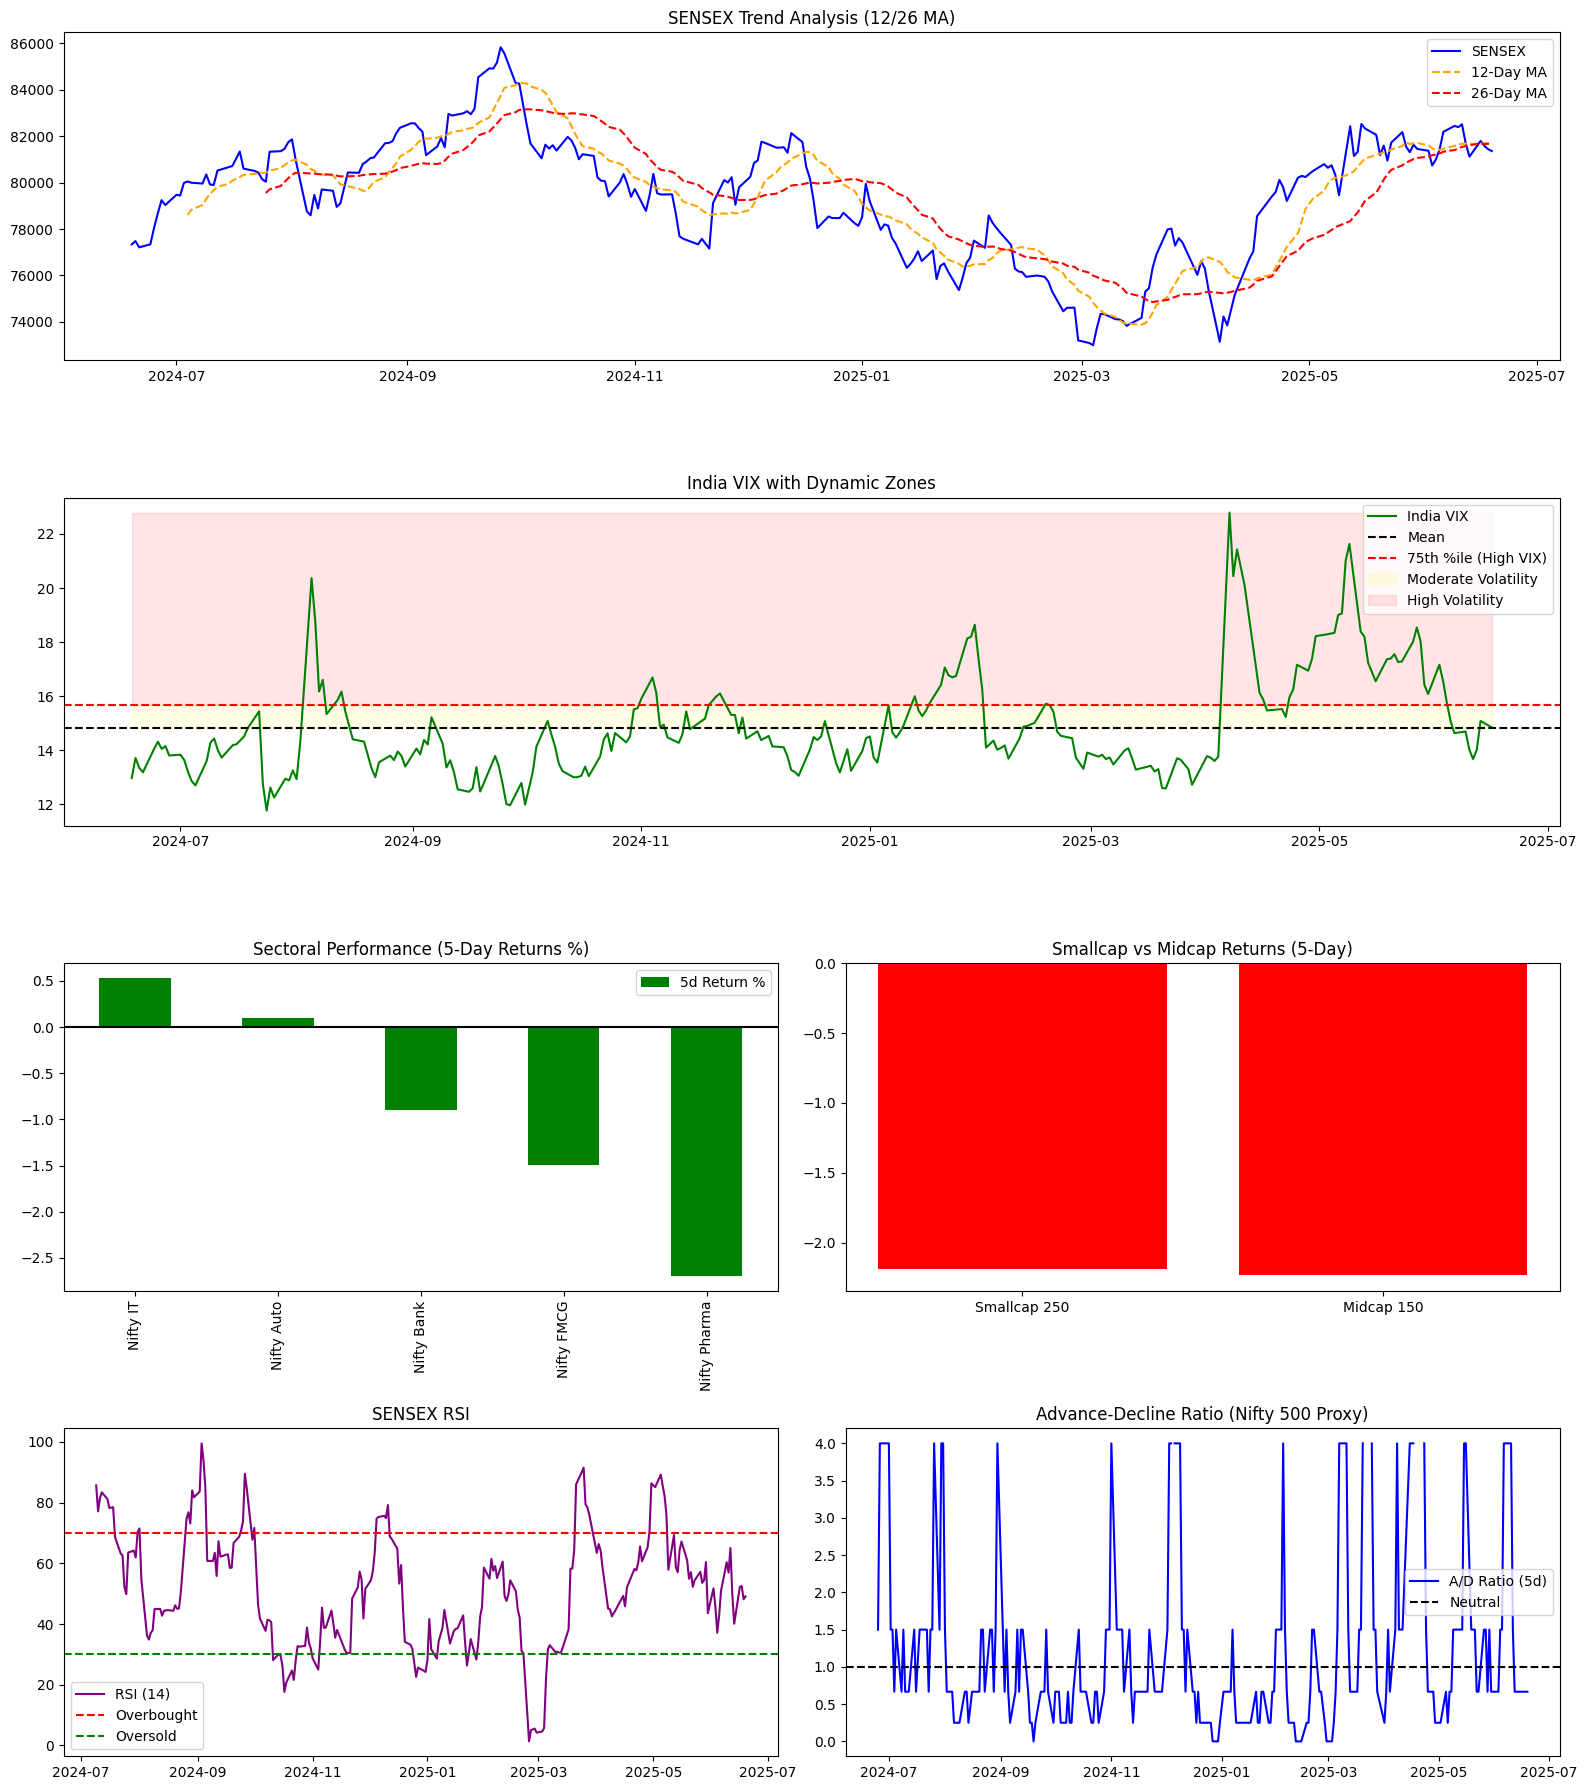

In [28]:

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

class MarketAnalyzer:
    def __init__(self, vix_data):
        self.vix_data = vix_data
        self.sensex = None
        self.nifty_smallcap = None
        self.nifty_midcap = None
        self.sector_data = None
        self.nifty_500 = None
        self._fetch_market_data()
        self._calculate_indicators()
        self._generate_signals()
        
    def _fetch_market_data(self):
        """Fetch all required market data"""
        # Benchmark Indices
        self.sensex = fetch_data("^BSESN")
        self.nifty_smallcap = fetch_data("0P0001PR8B.BO")  # SBI NIFTY Small-cap index 250
        self.nifty_midcap = fetch_data("0P0001NYM3.BO")    # ICICI Pru Nifty Midcap 150 Idx Reg Gr

        # Sectoral Indices
        sectors = {
            "Nifty Bank": "^NSEBANK",
            "Nifty IT": "^CNXIT",
            "Nifty FMCG": "^CNXFMCG",
            "Nifty Auto": "^CNXAUTO",
            "Nifty Pharma": "^CNXPHARMA",
        }
        self.sector_data = {sector: fetch_data(ticker, "3mo") for sector, ticker in sectors.items()}

        # For Advance-Decline Ratio
        self.nifty_500 = fetch_data("^CRSLDX")  # Nifty 500 (proxy)
        
    def _calculate_indicators(self):
        """Calculate all technical indicators"""
        # Moving Averages (12 and 26 days)
        self.sensex['MA_12'] = self.sensex['Close'].rolling(window=12).mean()
        self.sensex['MA_26'] = self.sensex['Close'].rolling(window=26).mean()

        # VIX Thresholds
        self.vix_mean = self.vix_data['vix_close'].mean()
        self.vix_std = self.vix_data['vix_close'].std()
        self.vix_75perc = np.percentile(self.vix_data['vix_close'], 75)

        # RSI (14-day)
        self.sensex['RSI'] = self._compute_rsi(self.sensex['Close'])

        # Advance-Decline Ratio
        self.nifty_500['Advance'] = self.nifty_500['Close'] > self.nifty_500['Open']
        self.nifty_500['Decline'] = self.nifty_500['Close'] < self.nifty_500['Open']
        self.ad_ratio = self.nifty_500['Advance'].sum() / max(self.nifty_500['Decline'].sum(), 1)

        # Sectoral Performance (5-day returns)
        self.sector_returns = pd.DataFrame({
            sector: data['Close'].pct_change(5).iloc[-1] * 100
            for sector, data in self.sector_data.items()
        }, index=["5d Return %"]).T.sort_values("5d Return %", ascending=False)

        # Smallcap/Midcap Performance
        self.smallcap_return = self.nifty_smallcap['Close'].pct_change(5).iloc[-1] * 100
        self.midcap_return = self.nifty_midcap['Close'].pct_change(5).iloc[-1] * 100
        
    def _compute_rsi(self, series, window=14):
        """Calculate RSI for given series"""
        delta = series.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.rolling(window).mean()
        avg_loss = loss.rolling(window).mean()
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
        
    def _generate_signals(self):
        """Generate all trading signals"""
        # Trend Signal
        self.trend = "Bullish" if (self.sensex['Close'].iloc[-1] > self.sensex['MA_12'].iloc[-1] and 
                                  self.sensex['Close'].iloc[-1] > self.sensex['MA_26'].iloc[-1]) else "Bearish"

        # VIX Signal
        current_vix = self.vix_data['vix_close'].iloc[-1]
        if current_vix < self.vix_mean:
            self.vix_sentiment = "Low (Bullish)"
        elif current_vix > self.vix_75perc:
            self.vix_sentiment = "Very High (Bearish)"
        else:
            self.vix_sentiment = "Moderate (Neutral)"

        # Sector Signal
        self.top_sector = self.sector_returns.index[0]
        if "Bank" in self.top_sector or "Auto" in self.top_sector or "IT" in self.top_sector:
            self.sector_sentiment = "Risk-On (Cyclicals Leading)"
        elif "FMCG" in self.top_sector or "Pharma" in self.top_sector:
            self.sector_sentiment = "Risk-Off (Defensives Leading)"
        else:
            self.sector_sentiment = "Neutral (Mixed)"

        # Breadth Signal
        if self.ad_ratio > 1.5:
            self.breadth_sentiment = "Broad Participation (Bullish)"
        elif self.ad_ratio < 0.7:
            self.breadth_sentiment = "Weak Participation (Bearish)"
        else:
            self.breadth_sentiment = "Neutral"

        # RSI Signal
        rsi = self.sensex['RSI'].iloc[-1]
        if rsi > 70:
            self.rsi_sentiment = "Overbought (Caution)"
        elif rsi < 30:
            self.rsi_sentiment = "Oversold (Opportunity)"
        else:
            self.rsi_sentiment = "Neutral"

        # Combined Signal
        if self.trend == "Bullish" and self.vix_sentiment == "Low (Bullish)" and "Risk-On" in self.sector_sentiment:
            self.combined_signal = "STRONG BULLISH"
        elif self.trend == "Bullish" and self.vix_sentiment == "Very High (Bearish)":
            self.combined_signal = "CAUTION (Bullish but fragile)"
        elif self.trend == "Bearish" and self.vix_sentiment == "Very High (Bearish)":
            self.combined_signal = "BEARISH"
        else:
            self.combined_signal = "NEUTRAL"
            
    def get_market_analysis(self):
        """Return a comprehensive market analysis dictionary"""
        return {
            "trend": {
                "current_price": self.sensex['Close'].iloc[-1],
                "ma_12": self.sensex['MA_12'].iloc[-1],
                "ma_26": self.sensex['MA_26'].iloc[-1],
                "trend": self.trend,
                "rsi": self.sensex['RSI'].iloc[-1],
                "rsi_sentiment": self.rsi_sentiment
            },
            "volatility": {
                "current_vix": self.vix_data['vix_close'].iloc[-1],
                "vix_mean": self.vix_mean,
                "vix_75th_percentile": self.vix_75perc,
                "vix_sentiment": self.vix_sentiment
            },
            "breadth": {
                "advance_decline_ratio": self.ad_ratio,
                "breadth_sentiment": self.breadth_sentiment,
                "smallcap_return": self.smallcap_return,
                "midcap_return": self.midcap_return
            },
            "sectors": {
                "sector_returns": self.sector_returns,
                "top_sector": self.top_sector,
                "sector_sentiment": self.sector_sentiment,
                "weakest_sector": self.sector_returns.index[-1]
            },
            "combined_signal": self.combined_signal
        }
        
    def get_trading_recommendation(self):
        """Get a trading recommendation based on the analysis"""
        analysis = self.get_market_analysis()
        
        if analysis["combined_signal"] == "STRONG BULLISH":
            return {
                "action": "BUY",
                "confidence": "High",
                "reason": "Broad rally with low volatility and cyclicals leading",
                "focus_sectors": [s for s in self.sector_returns.index if "Bank" in s or "Auto" in s or "IT" in s]
            }
        elif analysis["combined_signal"] == "BEARISH":
            return {
                "action": "SELL or SHORT",
                "confidence": "High",
                "reason": "Downtrend with high volatility and defensive sectors leading",
                "hedge_sectors": [s for s in self.sector_returns.index if "FMCG" in s or "Pharma" in s]
            }
        elif analysis["combined_signal"] == "CAUTION (Bullish but fragile)":
            return {
                "action": "HOLD or Light BUY with tight stops",
                "confidence": "Medium",
                "reason": "Bullish trend but volatility is high indicating potential reversal",
                "focus_sectors": [s for s in self.sector_returns.index if "FMCG" in s or "Pharma" in s]
            }
        else:  # NEUTRAL
            return {
                "action": "HOLD or Wait",
                "confidence": "Low",
                "reason": "Mixed signals in the market",
                "suggested_action": "Wait for clearer trend confirmation"
            }
            
    def plot_analysis(self):
        """Generate analysis plots"""
        plt.figure(figsize=(16, 18))
        gs = GridSpec(4, 2, figure=plt.gcf())

        # Plot 1: SENSEX and MAs
        ax1 = plt.subplot(gs[0, :])
        ax1.plot(self.sensex['Close'], label='SENSEX', color='blue')
        ax1.plot(self.sensex['MA_12'], label='12-Day MA', linestyle='--', color='orange')
        ax1.plot(self.sensex['MA_26'], label='26-Day MA', linestyle='--', color='red')
        ax1.set_title('SENSEX Trend Analysis (12/26 MA)')
        ax1.legend()

        # Plot 2: India VIX Zones
        ax2 = plt.subplot(gs[1, :])
        ax2.plot(self.vix_data['vix_close'], label='India VIX', color='green')
        ax2.axhline(y=self.vix_mean, linestyle='--', color='black', label='Mean')
        ax2.axhline(y=self.vix_75perc, linestyle='--', color='red', label='75th %ile (High VIX)')
        ax2.fill_between(self.vix_data.index, self.vix_mean, self.vix_75perc, color='yellow', alpha=0.1, label='Moderate Volatility')
        ax2.fill_between(self.vix_data.index, self.vix_75perc, self.vix_data['vix_close'].max(), color='red', alpha=0.1, label='High Volatility')
        ax2.set_title('India VIX with Dynamic Zones')
        ax2.legend()

        # Plot 3: Sectoral Heatmap
        ax3 = plt.subplot(gs[2, 0])
        self.sector_returns.plot(kind='bar', ax=ax3, color=['green' if x > 0 else 'red' for x in self.sector_returns['5d Return %']])
        ax3.axhline(y=0, color='black', linestyle='-')
        ax3.set_title('Sectoral Performance (5-Day Returns %)')

        # Plot 4: Smallcap vs Midcap
        ax4 = plt.subplot(gs[2, 1])
        ax4.bar(['Smallcap 250', 'Midcap 150'], [self.smallcap_return, self.midcap_return], 
                color=['green' if x > 0 else 'red' for x in [self.smallcap_return, self.midcap_return]])
        ax4.set_title('Smallcap vs Midcap Returns (5-Day)')

        # Plot 5: RSI
        ax5 = plt.subplot(gs[3, 0])
        ax5.plot(self.sensex['RSI'], label='RSI (14)', color='purple')
        ax5.axhline(y=70, linestyle='--', color='red', label='Overbought')
        ax5.axhline(y=30, linestyle='--', color='green', label='Oversold')
        ax5.set_title('SENSEX RSI')
        ax5.legend()

        # Plot 6: Advance-Decline Ratio
        ax6 = plt.subplot(gs[3, 1])
        ax6.plot(self.nifty_500.index, self.nifty_500['Advance'].rolling(5).sum() / self.nifty_500['Decline'].rolling(5).sum(), 
                 label='A/D Ratio (5d)', color='blue')
        ax6.axhline(y=1.0, linestyle='--', color='black', label='Neutral')
        ax6.set_title('Advance-Decline Ratio (Nifty 500 Proxy)')
        ax6.legend()

        plt.tight_layout()
        return plt

# Helper function (outside class)
def fetch_data(ticker, period="1y"):
    """Fetch data from Yahoo Finance"""
    tck = yf.Ticker(ticker)
    return tck.history(period=period)

# Example usage:
if __name__ == "__main__":
    # First get your VIX data (example)
    vix_data = load_and_preprocess_vix_data()
    
    # Create analyzer instance
    analyzer = MarketAnalyzer(vix_data)
    
    # Get market analysis
    analysis = analyzer.get_market_analysis()
    print("Market Analysis:")
    print(analysis)
    
    # Get trading recommendation
    recommendation = analyzer.get_trading_recommendation()
    print("\nTrading Recommendation:")
    print(recommendation)
    
    # Show plots
    plt = analyzer.plot_analysis()
    plt.show()